# Exercise 14: Gamma ray bursts
 - The database can be downloaded at https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt
 - You can find the physical meaning of each variable at https://user-web.icecube.wisc.edu/~grbweb_public/Variables.html 

 Some relevant physical questions you might want to tackle include:

- Does the distribution contain different sub-populations? How many?
- What's the threshold between the classes?
- If you try two clustering methods, do you get more or less the same?
- How do methods respond to outliers?
- What variable(s) shows the multi-modality more evidently?
- Are all GRBs equally likely to be observed?

---

In [3]:
import numpy as np
import pylab as plt
import requests
from scipy.stats import norm

from sklearn.neighbors import KernelDensity
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [74]:
# Download file
r = requests.get('https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt')
with open("Summary_table.txt", 'wb') as f:
    f.write(r.content)

In [75]:
# Read headers
with open("Summary_table.txt",'r') as f:
    names= np.array([n.strip().replace(" ","_") for n in f.readlines()[1].replace("#","").replace("\n","").lstrip().split('    ') if n.strip()!=''])

print(names)
names.shape

['GRB_name' 'GRB_name_Fermi' 'T0' 'ra' 'decl' 'pos_error' 'T90'
 'T90_error' 'T90_start' 'fluence' 'fluence_error' 'redshift' "'T100'"
 'GBM_located' 'mjd_(T0)']


(15,)

In [76]:
# Read content
data = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')
data.shape


(15, 8010)

In [77]:
#Pack into python dictionary and convert selected fields to float
grb=dict(zip(names,data))

for lab in ['ra',"decl","pos_error",'T90', 'T90_error', 'fluence', 'fluence_error']:
    grb[lab] = np.array(grb[lab],dtype='float')


## Spatial distribution

Text(0.5, 1.0, 'decl')

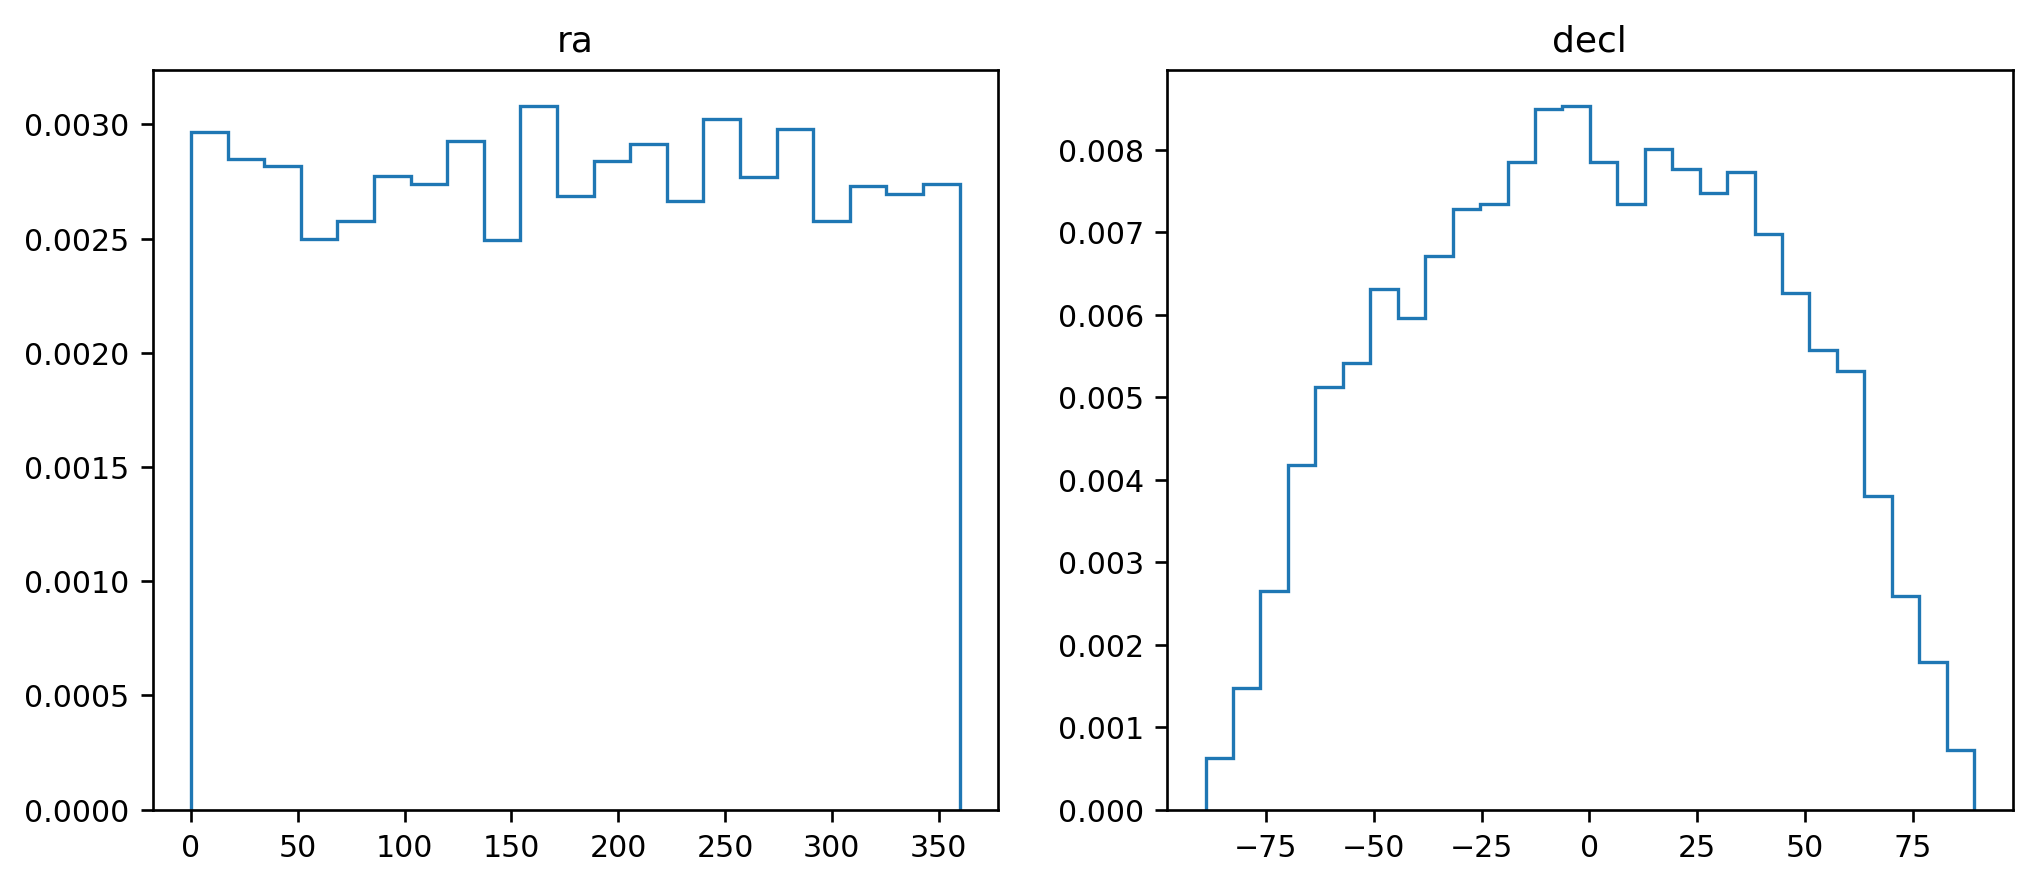

In [78]:
ra = grb['ra']
decl = grb['decl']

#-------  Plt params  ----------------
%config InlineBackend.figure_format='retina'
plt.rc('figure', figsize=(10, 4), dpi=120)
plt.rcParams.update({'font.size': 9})
#--------------------------------------------

fig,ax = plt.subplots(1,2)
ax[0].hist(ra, histtype='step', bins='auto', density=True)
ax[0].set_title('ra')
ax[1].hist(decl, histtype='step', bins='auto', density=True)
ax[1].set_title('decl')

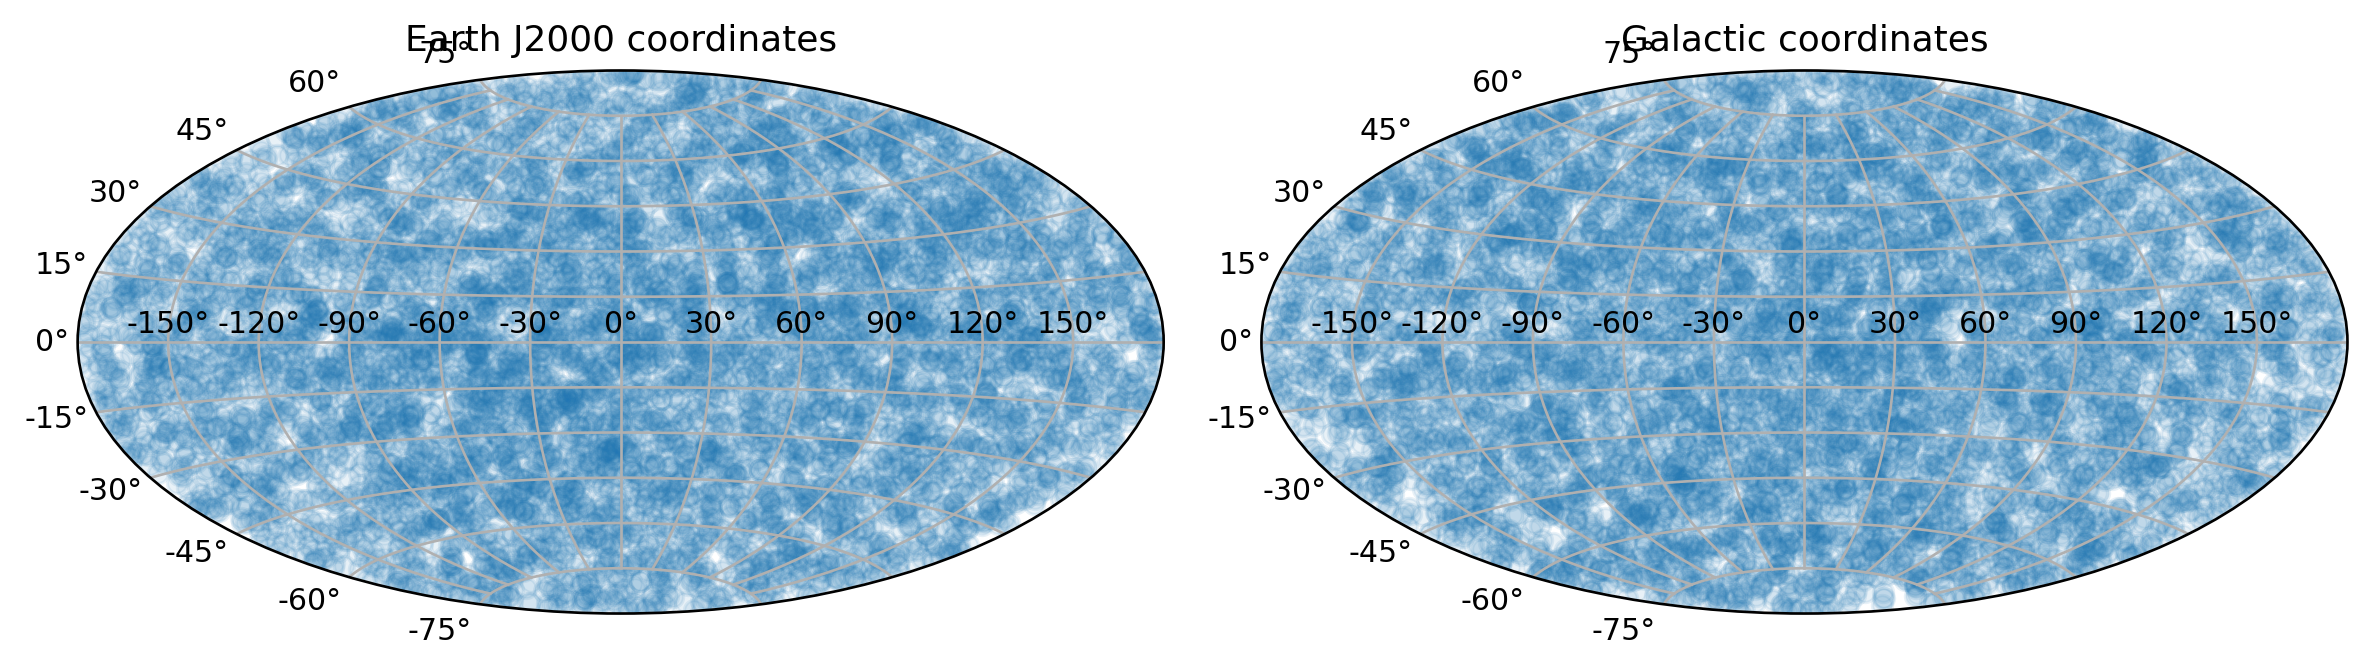

In [79]:
from astropy.coordinates import SkyCoord
import astropy.units as u

eq = SkyCoord(ra, decl, unit=u.deg)
gal = eq.galactic

#-------  Plt params  ----------------
%config InlineBackend.figure_format='retina'
plt.rc('figure', figsize=(10, 4), dpi=120)
plt.rcParams.update({'font.size': 9})
#--------------------------------------------

fig=plt.figure()

ax1=fig.add_subplot(121,  projection='aitoff')
ax1.grid(True)
ax1.scatter(gal.l.wrap_at('180d').radian, gal.b.radian, alpha = 0.1)
ax1.set_title('Earth J2000 coordinates')

ax2=fig.add_subplot(122,  projection='aitoff')
ax2.grid(True)
ax2.scatter(eq.ra.wrap_at('180d').radian, eq.dec.radian, alpha = 0.1)
ax2.set_title('Galactic coordinates')

plt.tight_layout()


Distribution seems uniform in the sky, no major concentration on the galactic plane

## Time and fluence
We will study log(t) and log(fluence)

Text(0.5, 1.0, 'fluence')

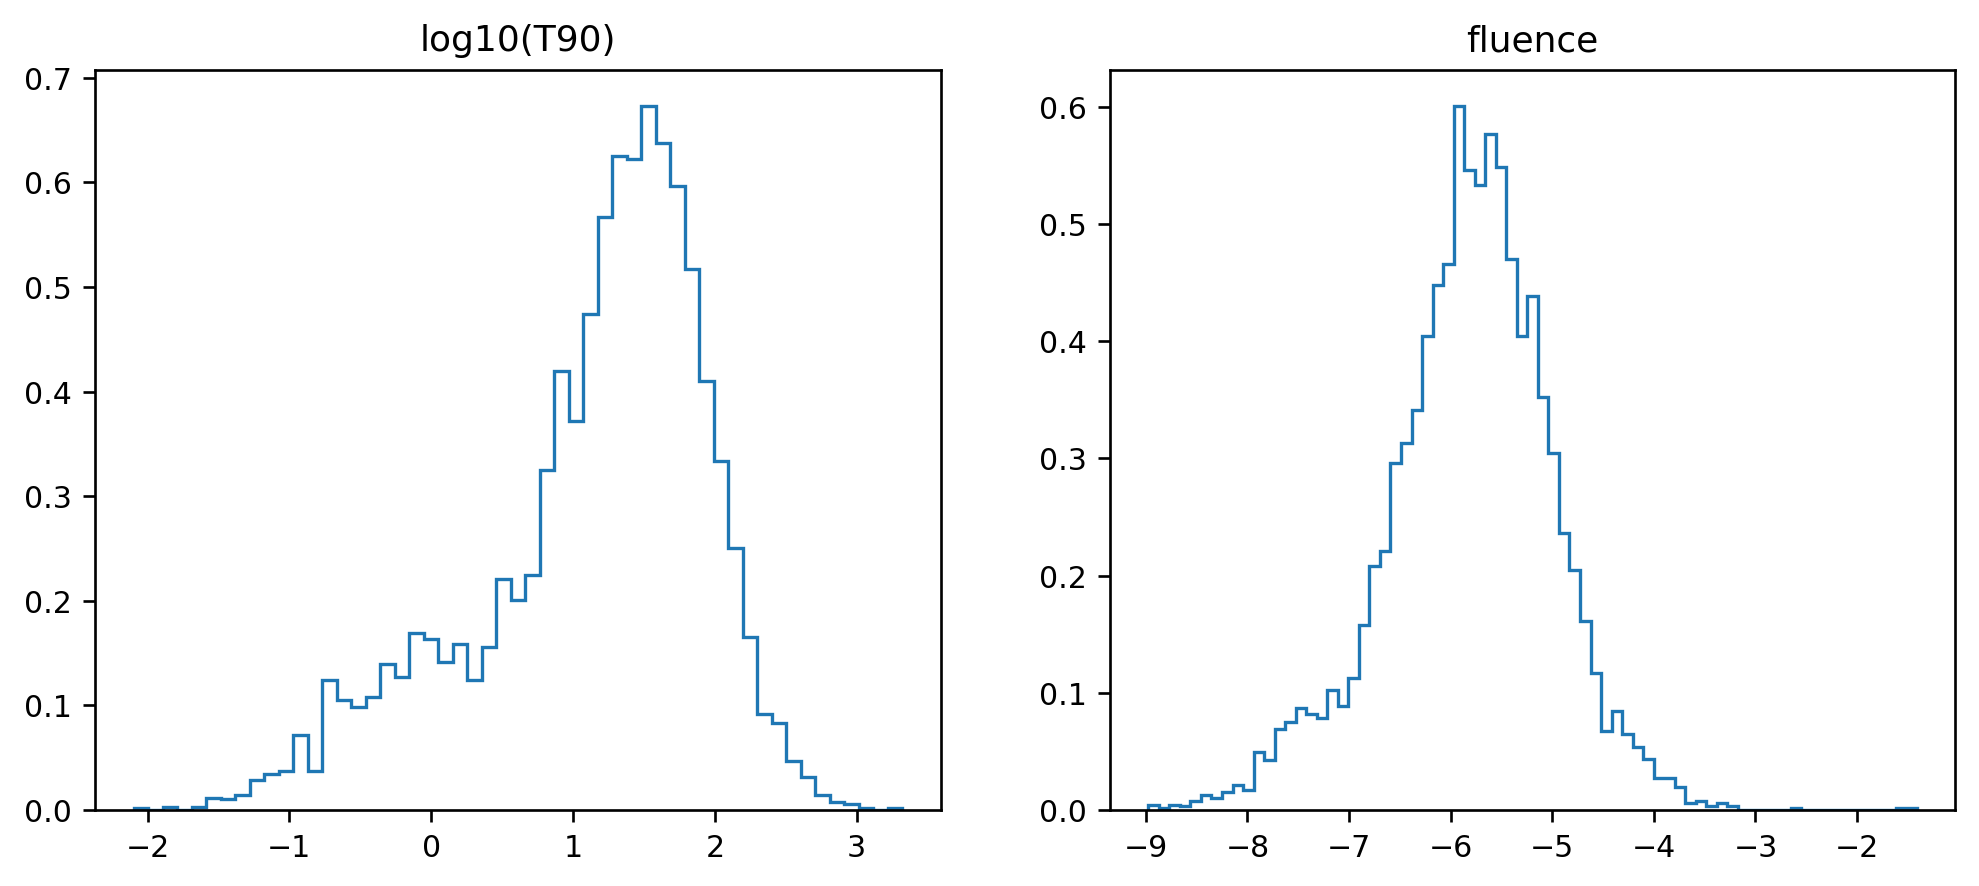

In [82]:
t = grb['T90']
fluence = grb['fluence']

mask = (t > 0) & (fluence > 0)

fluence = np.log10(fluence[mask])
t = np.log10(t[mask])

#-------  Plt params  ----------------
%config InlineBackend.figure_format='retina'
plt.rc('figure', figsize=(10, 4), dpi=120)
plt.rcParams.update({'font.size': 9})
#--------------------------------------------

fig,ax = plt.subplots(1,2)
ax[0].hist(t, histtype='step', bins='auto', density=True)
ax[0].set_title('log10(T90)')
ax[1].hist(fluence, histtype='step', bins='auto', density=True)
ax[1].set_title('fluence')

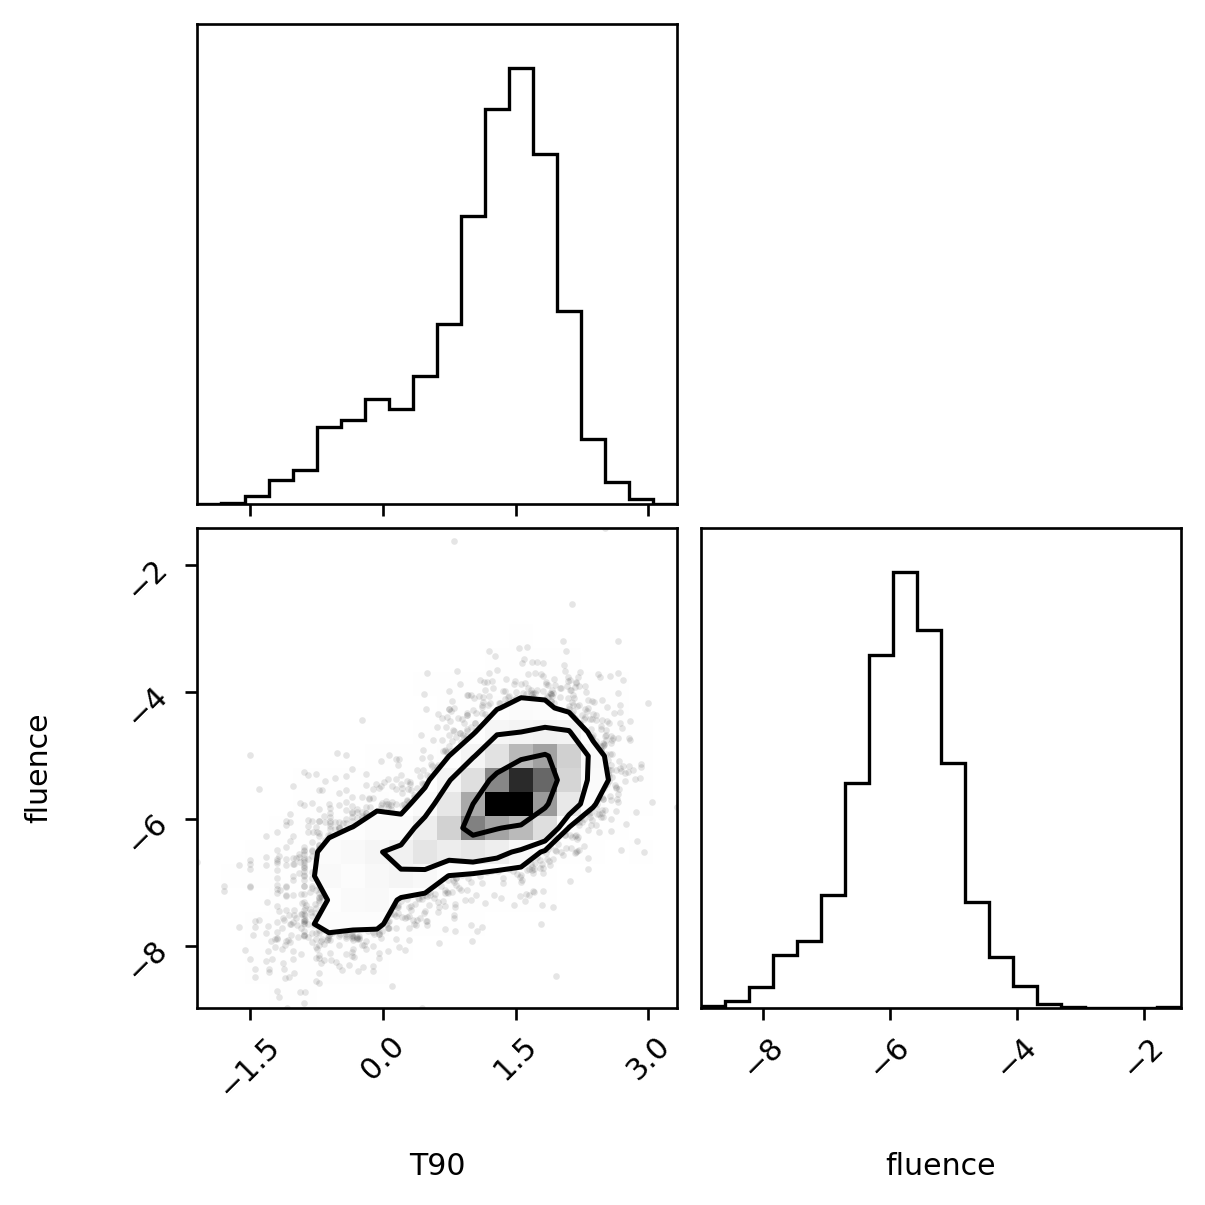

In [85]:
import corner
corner.corner(np.vstack((t,fluence)).T, labels=['T90','fluence']);

In [48]:
from astroML.utils.decorators import pickle_results
# KDE with Cross validation

X_t = t[:,None]
X_f = fluence[:,None]

K = 7

@pickle_results('double_cv.pkl')
def double_cv():
    best_bw=[]
    for X in [X_t,X_f]:
        bwrange = np.linspace(0.05, 0.5, 10)
        grid = GridSearchCV(KernelDensity(kernel='gaussian'), {'bandwidth': bwrange}, cv = K)
        grid.fit(X)

        best_bw.append( grid.best_params_['bandwidth'])

    return best_bw

best_bw = double_cv()

@pickle_results: using precomputed results from 'double_cv.pkl'


In [49]:
best_bw

[0.1, 0.25]

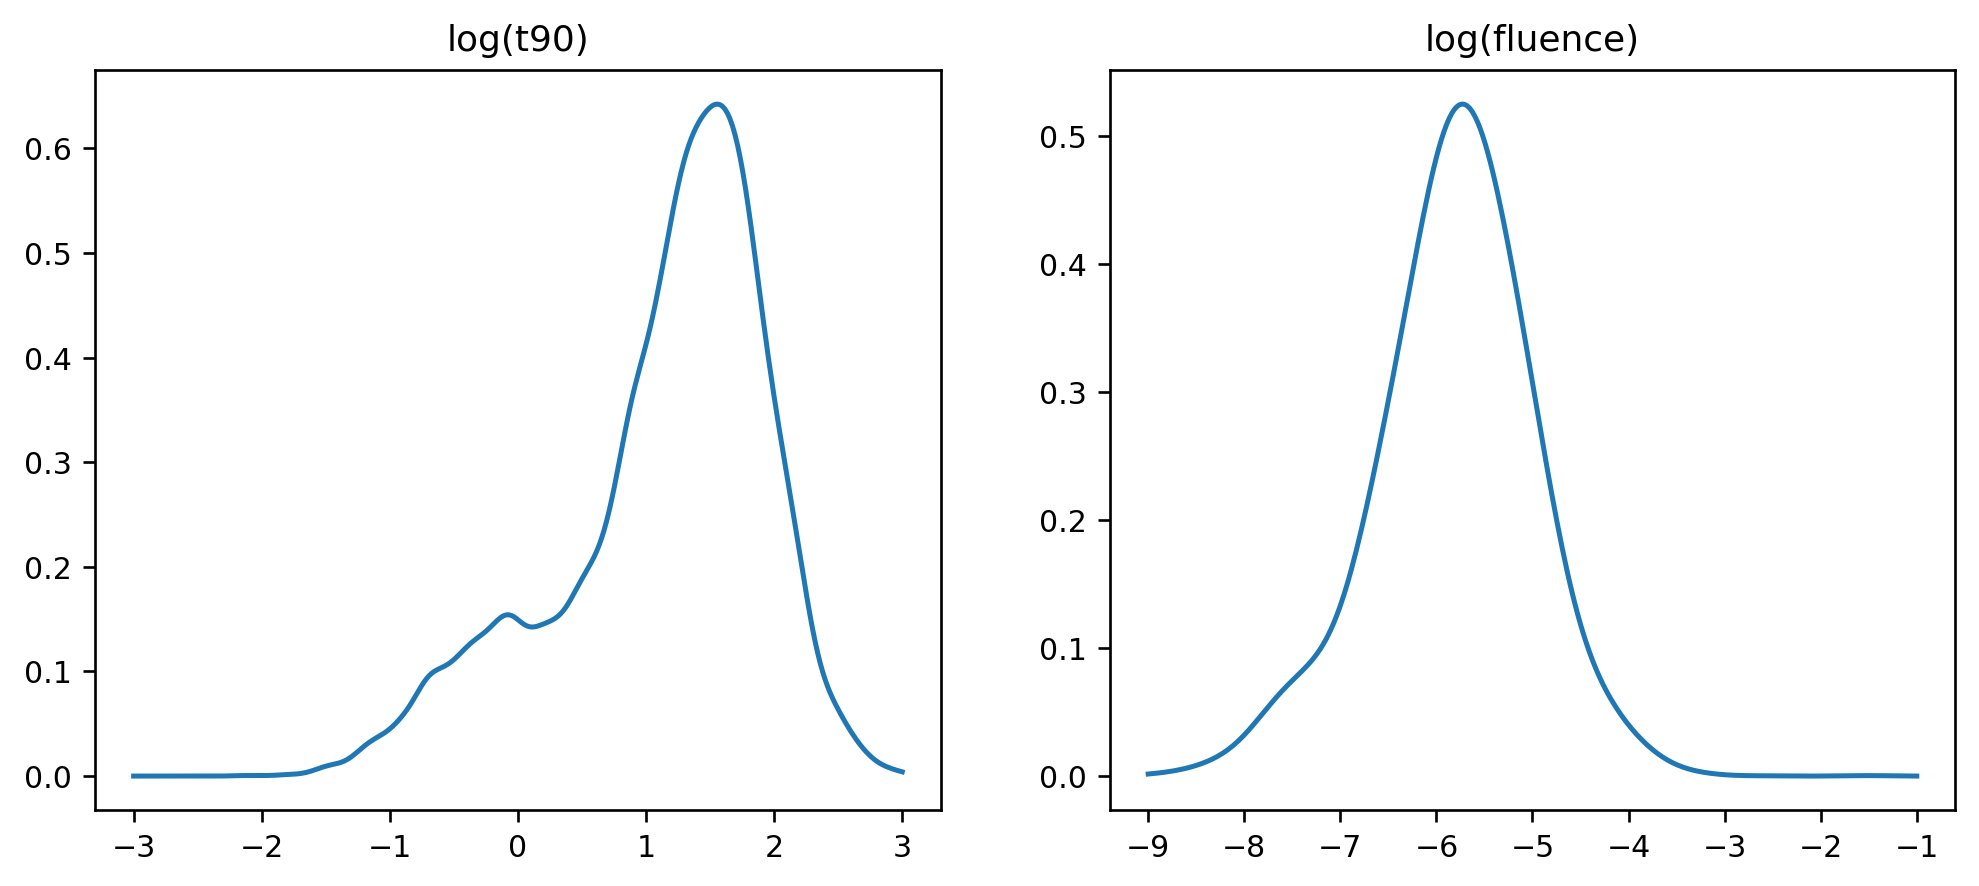

In [50]:


xgrid_t=np.linspace(-3,3,300)
xgrid_f=np.linspace(-9,-1,300)

fig, axes = plt.subplots(1,2)
titles = ['log(t90)', 'log(fluence)']

for ax, X, xgrid, bw,title in zip(axes, [X_t,X_f], [xgrid_t, xgrid_f], best_bw,titles):
    kde = KernelDensity(bandwidth = bw, kernel='gaussian')
    kde.fit(X)
    ygrid = np.exp(kde.score_samples(xgrid[:,np.newaxis]))
    ax.plot(xgrid, ygrid)
    ax.set_title(title);


We can see a quite clear bimodality in t90, just a little bump in fluence.  We will start with exploring the time feature.

In [51]:
from sklearn.mixture import GaussianMixture
X=X_t
mix = GaussianMixture(2)
mix.fit(X)

GaussianMixture(n_components=2)

Text(0.5, 0, 'T90 [$s$]')

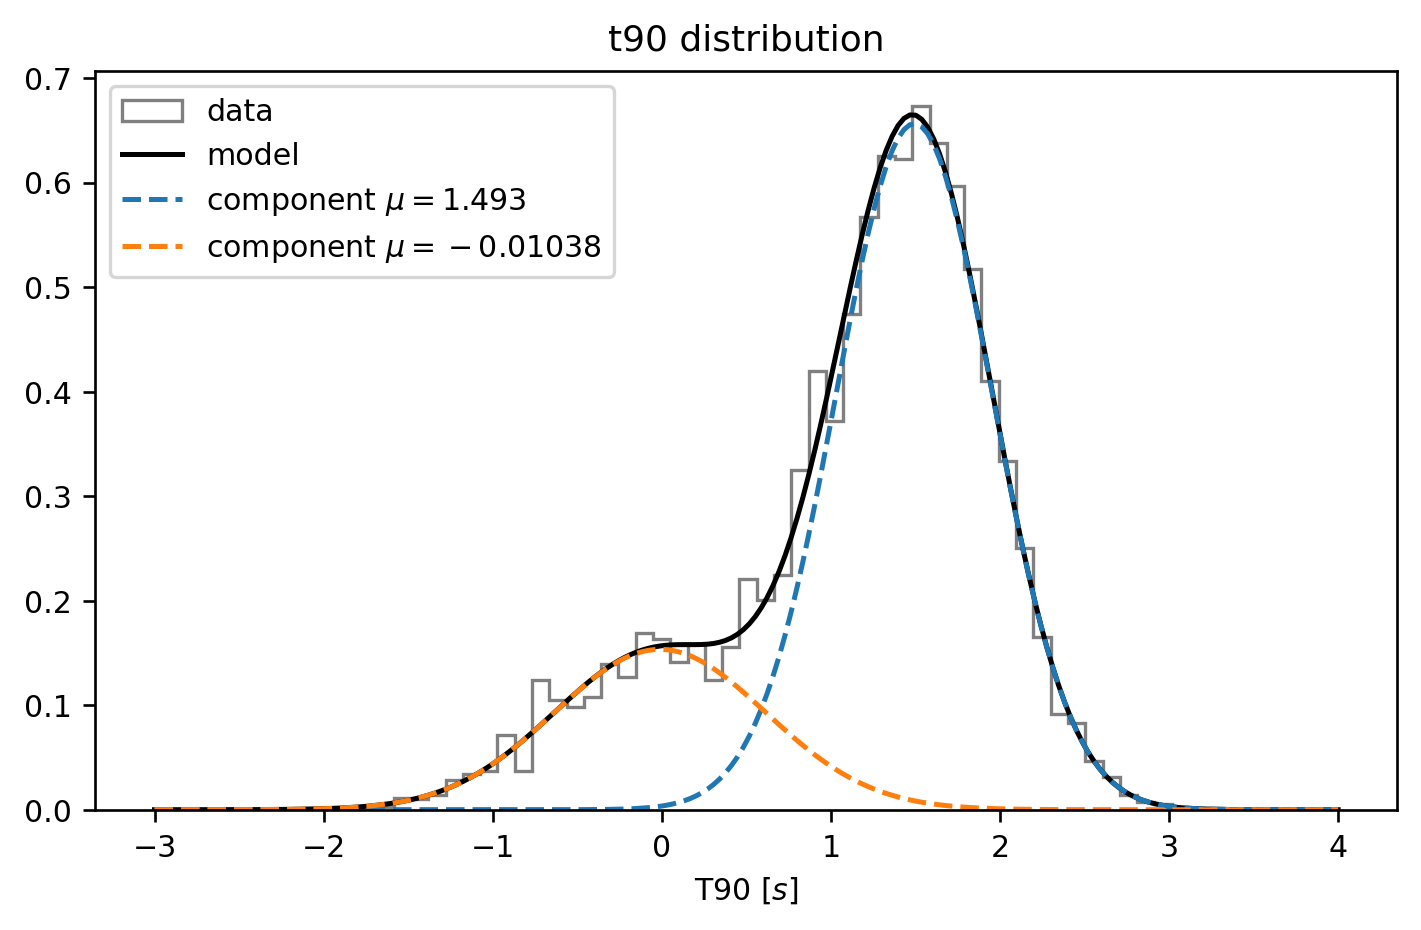

In [52]:
from scipy.stats import norm
mix_best = mix

x_grid = np.linspace(-3,4,200)
logl = mix_best.score_samples(x_grid[:,np.newaxis])
prob = np.exp(logl)

means = mix_best.means_
weights = mix_best.weights_
sigmas = np.sqrt(mix_best.covariances_)

#-------  Plt params  ----------------
%config InlineBackend.figure_format='retina'
plt.rc('figure', figsize=(7, 4), dpi=120)
plt.rcParams.update({'font.size': 9})
#--------------------------------------------

plt.hist(t, bins='auto', density=True, histtype='step', color='grey', label='data')
plt.plot(x_grid,prob, c='k', label='model')

for a, mu, sigma in zip(weights,means[:,0],sigmas[:,0,0]):
    dist = norm(loc=mu, scale=sigma).pdf
    plt.plot(x_grid, a*dist(x_grid), ls='--', label=f'component $\mu = {mu:.4}$')

plt.legend()
plt.title('t90 distribution')
plt.xlabel(r'T90 [$s$]')

Quite nice, we can recognize 2 different populations. Since this is in log, the duration of the lower population is about 1-1,5 orders of magnitude lower, could be from different physics phenomena.

Now let's try clustering.

In [53]:
# from sklearn.cluster import MeanShift

# ms = MeanShift()
# ms.fit(X)
# ms.cluster_centers_

MeansShift does not recognize the two modes, only the bigger one. Let's try K-means

In [54]:
from sklearn.cluster import KMeans

kmean = KMeans(n_clusters=2)
kmean.fit(X)
centers = kmean.cluster_centers_.T[0]
print(centers)

[-0.03751132  1.52597491]


In [55]:
labels = kmean.predict(X)
decision = np.mean( [max(X[labels==0]), min(X[labels==1]) ])

K_means works quite well, it recognizes the two populations, let's see the decision boundary

Text(0.5, 0, '$\\log_{10}$T90 [$s$]')

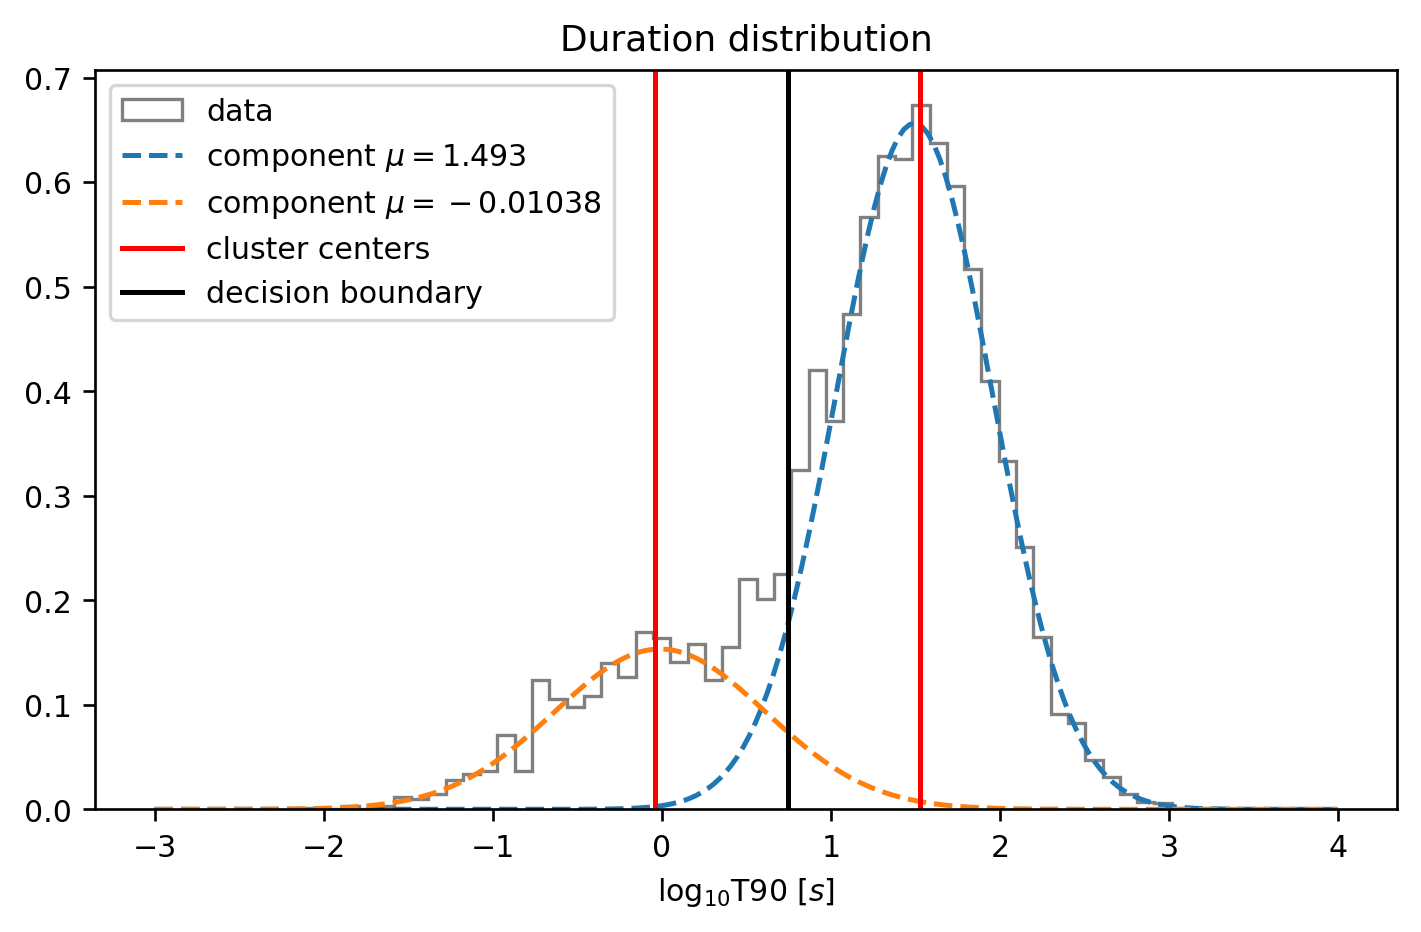

In [56]:
#-------  Plt params  ----------------
%config InlineBackend.figure_format='retina'
plt.rc('figure', figsize=(7, 4), dpi=120)
plt.rcParams.update({'font.size': 9})
#--------------------------------------------

plt.hist(t, bins='auto', density=True, histtype='step', color='grey', label='data')
# plt.plot(x_grid,prob, c='k', label='model')

for a, mu, sigma in zip(weights,means[:,0],sigmas[:,0,0]):
    dist = norm(loc=mu, scale=sigma).pdf
    plt.plot(x_grid, a*dist(x_grid), ls='--', label=f'component $\mu = {mu:.4}$')

plt.axvline(centers[0], c='red' , label='cluster centers')
plt.axvline(centers[1], c='red')
plt.axvline(decision, c='k', label = 'decision boundary')



plt.legend()
plt.title('Duration distribution')
plt.xlabel(r'$\log_{10}$T90 [$s$]')

Let's try to run K-Means on the 2D t90 - fluence subspace, and compare the two class divions.


In [57]:
X_2d = np.vstack((t,fluence)).T

clf = KMeans(n_clusters = 2)

clf.fit(X_2d)
centers_2d = clf.cluster_centers_ 
labels_2d = clf.predict(X_2d)

centers_2d

array([[ 1.53485938, -5.47301331],
       [ 0.06823566, -6.73558482]])

Text(0.5, 1.0, '1D K-Means clustering on t90 feature')

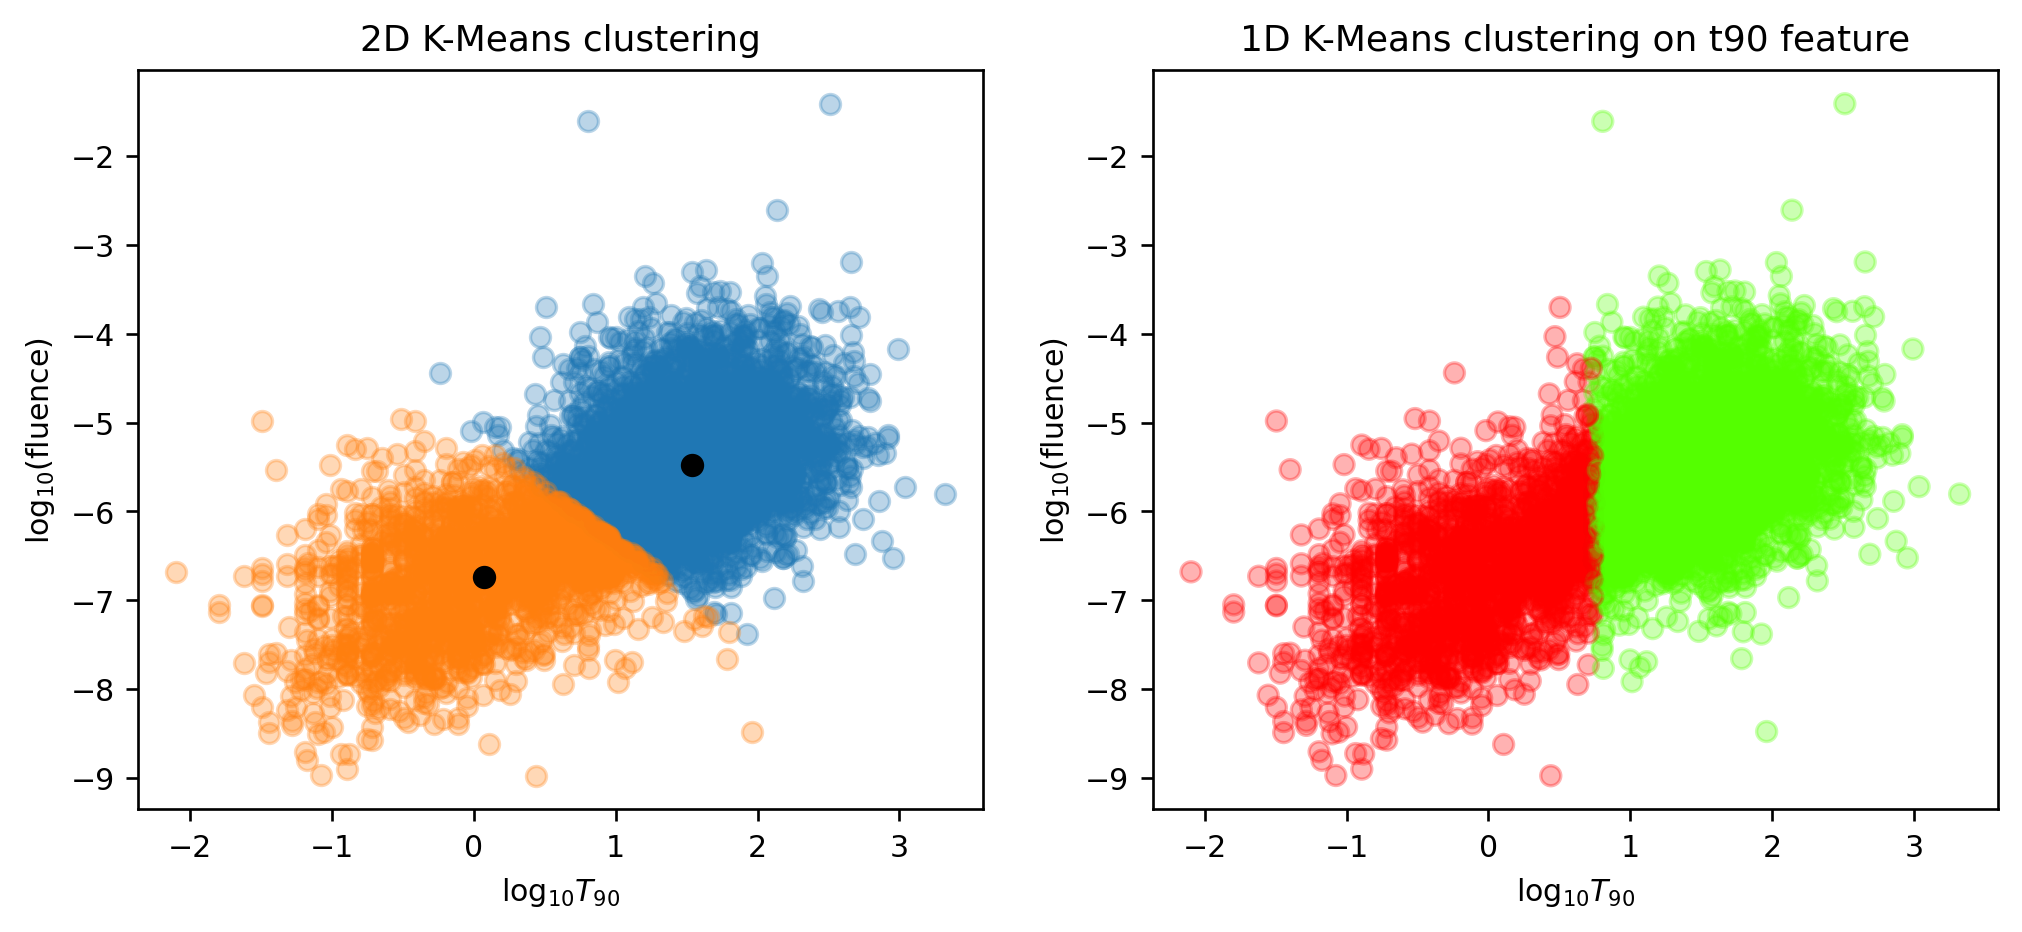

In [63]:
#-------  Plt params  ----------------
%config InlineBackend.figure_format='retina'
plt.rc('figure', figsize=(10, 4), dpi=120)
plt.rcParams.update({'font.size': 9})
#--------------------------------------------

ax = plt.subplot(121)
for i in range(2):
    ax.scatter(X_2d[labels_2d == i, 0], X_2d[labels_2d == i, 1], alpha = 0.3)
ax.scatter(centers_2d[:, 0], centers_2d[:, 1], c='k')

ax.set_xlabel(r'$\log_{10}T_{90}$')
ax.set_ylabel(r'$\log_{10}$(fluence)')
ax.set_title('2D K-Means clustering')

ax = plt.subplot(122)
ax.scatter(t,fluence, c=labels, cmap='prism' , edgecolors=None, alpha=0.3)
ax.set_xlabel(r'$\log_{10}T_{90}$')
ax.set_ylabel(r'$\log_{10}$(fluence)')
ax.set_title('1D K-Means clustering on t90 feature')


The divison is very similar: this is consistent with the observation that the t90 feature have the most clear bimodality. We also see a positive correlation between fluence and duration of the GRB: it is expected as fluence is the time integrated total energy per unit surface.

## PCA
Let's try PCA with sub-space log(T90) vs log(fluence) vs redshift

In [10]:
data = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')

indexes = (6,9,11)
t90, fluence, redshift = data[indexes,:].astype(float)

mask = (t90 > 0) & (fluence > 0) & (redshift > 0) 

data_pca = np.vstack((np.log10(t90[mask]), np.log10(fluence[mask]), redshift[mask]))
# data_pca = np.vstack((ra[mask], decl[mask],t90[mask], fluence[mask], redshift[mask]))


t90, fluence, redshift  = data_pca #use lof of time and fluence
X_pca = data_pca.T


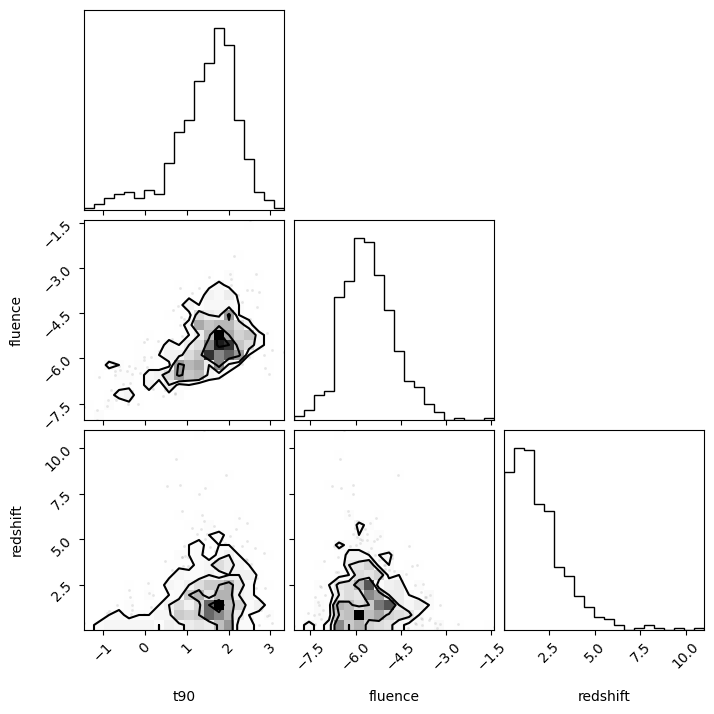

In [14]:
import corner

corner.corner(X_pca, labels=[ 't90', 'fluence', 'redshift']);

All distribution are quite well behaved

Text(0, 0.5, 'Eigenvalue 2')

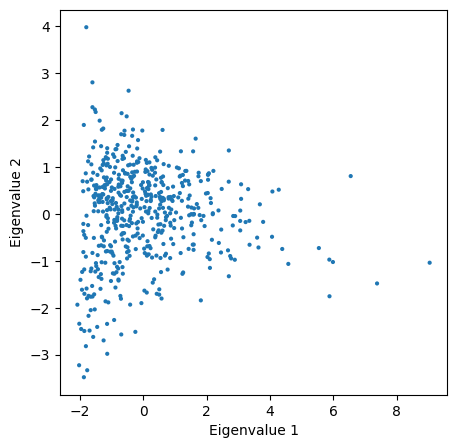

In [12]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2) 
pca.fit(X_pca) 

X_reduced = pca.transform(X_pca)

fig = plt.figure(figsize=(5, 5))

ax = fig.add_subplot()
ax.scatter(X_reduced[:,0], X_reduced[:,1], 
            marker=".", color='C0', 
            alpha=1, edgecolors='None')
ax.set_xlabel('Eigenvalue 1')
ax.set_ylabel('Eigenvalue 2')

In [13]:
print(pca.explained_variance_ratio_)
print(pca.components_)


[0.6437057  0.27932401]
[[ 0.11657859 -0.04151733  0.99231333]
 [ 0.62296545  0.7812001  -0.04050242]]


No interesting structures are highlighted by PCA, this is basically an almost-equally weighted combination of t90 and fluence vs redshift